###Install dependencies

Make sure to select GPU-runtime (Change runtime type)

In [ ]:
!pip install simpletransformers tqdm==4.46.1 wandb

In [96]:
%%writefile setup.sh
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Overwriting setup.sh


In [ ]:
!sh setup.sh # this takes a while

Restart Runtime onece above is installed, and continue with cells below

###Upload dataset

In [1]:
# Allow Google Cloud SDK to access the dataset.pkl file in your google drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
# Get your link by right clicking on file dataset.pkl in google dirive and selecting copy shareable link
# Should be on the form https://drive.google.com/file/d/1L_6xCAF_ozZockbw_Xe7h1ocr_CkILyI/view?usp=sharing
# Copy the id part and paste as id below
id='1L_6xCAF_ozZockbw_Xe7h1ocr_CkILyI'
downloaded = drive.CreateFile({'id':id})
!mkdir -p dataset
downloaded.GetContentFile('dataset/dataset.pkl') 

### Preprocess dataset

In [3]:
import pandas as pd
df = pd.read_pickle('dataset/dataset.pkl')

In [4]:
df

,body,lewissplit,title,topics
0,Inco Ltd said it did not expect its earlier re...,TRAIN,INCO SEES NO MAJOR IMPACT FROM DOW REMOVAL,[]
1,"Mason Benson, former president and chief opera...",TRAIN,FORMER EMPIRE OF CAROLINA <EMP> EXEC SENTENCED,[]
2,In a discovery that could complicate the searc...,TRAIN,"DOCTORS FIND LINK BETWEEN AIDS, SMALLPOX VIRUS",[]
3,Doctors at the Centers for Disease Control in ...,TRAIN,BIRTH CONTROL PILLS HELP PREVENT CANCER - STUDY,[]
4,U.S. economic data this week could be the key ...,TRAIN,U.S. ECONOMIC DATA KEY TO DEBT FUTURES OUTLOOK,"[interest, retail, ipi]"
...,...,...,...,...
21573,The Japan/India-Pakistan-Gulf/Japan shipping c...,TEST,JAPAN/INDIA CONFERENCE CUTS GULF WAR RISK CHARGES,[ship]
21574,The Soviet Union's industrial output is growin...,TEST,SOVIET INDUSTRIAL GROWTH/TRADE SLOWER IN 1987,[ipi]
21575,Six black miners have been killed and two inju...,TEST,SIX KILLED IN SOUTH AFRICAN GOLD MINE ACCIDENT,[gold]
21576,The prospect of a dominant alliance of sociali...,TEST,PROJECTIONS SHOW SWISS VOTERS WANT TRIED PARTIES,[]


In [5]:
df[df.topics.apply(lambda x: len(x)) == 0]

,body,lewissplit,title,topics
0,Inco Ltd said it did not expect its earlier re...,TRAIN,INCO SEES NO MAJOR IMPACT FROM DOW REMOVAL,[]
1,"Mason Benson, former president and chief opera...",TRAIN,FORMER EMPIRE OF CAROLINA <EMP> EXEC SENTENCED,[]
2,In a discovery that could complicate the searc...,TRAIN,"DOCTORS FIND LINK BETWEEN AIDS, SMALLPOX VIRUS",[]
3,Doctors at the Centers for Disease Control in ...,TRAIN,BIRTH CONTROL PILLS HELP PREVENT CANCER - STUDY,[]
5,"The Reagan administration, responding to last ...",TRAIN,"U.S. ""ACTION PROGRAM"" FOR SUB-SAHARAN AFRICA",[]
...,...,...,...,...
21565,The Ministry of Finance has started to conside...,TEST,JAPAN STARTS CONSIDERING NOVEMBER BOND COUPON,[]
21568,Orders for non-fuel imports placed in August r...,TEST,NEW ZEALAND NON-FUEL IMPORT ORDERS RISE IN AUGUST,[]
21571,An announcement by Alliant Computer Systems In...,TEST,COMPETITION TOUGHENS FOR NEAR-SUPERCOMPUTERS,[]
21576,The prospect of a dominant alliance of sociali...,TEST,PROJECTIONS SHOW SWISS VOTERS WANT TRIED PARTIES,[]


In [6]:
num_nonempty_docs = len(df) - len(df[df.topics.apply(lambda x: len(x)) == 0])
print('num_nonempty_docs:', num_nonempty_docs)

num_nonempty_docs: 11367


Quite many documents without any tags

In [7]:
# Merge title and text
df['text'] = df.title + '\n' + df.body

9912


(array([7.780e+03, 7.491e+03, 2.466e+03, 1.339e+03, 8.790e+02, 4.620e+02,
        3.170e+02, 2.500e+02, 1.740e+02, 1.260e+02, 1.190e+02, 8.600e+01,
        5.400e+01, 2.200e+01, 6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00]),
 array([1.00000e+00, 3.97440e+02, 7.93880e+02, 1.19032e+03, 1.58676e+03,
        1.98320e+03, 2.37964e+03, 2.77608e+03, 3.17252e+03, 3.56896e+03,
        3.96540e+03, 4.36184e+03, 4.75828e+03, 5.15472e+03, 5.55116e+03,
        5.94760e+03, 6.34404e+03, 6.74048e+03, 7.13692e+03, 7.53336e+03,
        7.92980e+03, 8.32624e+03, 8.72268e+03, 9.11912e+03, 9.51556e+03,
        9.91200e+03]),
 <a list of 25 Patch objects>)

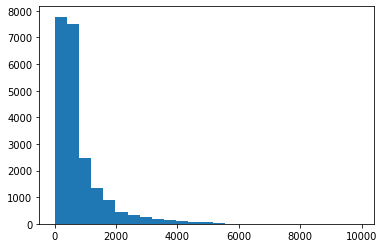

In [8]:
# Plot histogram of string length
import matplotlib.pyplot as plt
print(max(df.text.apply(lambda x: len(x))))
plt.hist(df.text.str.len(), bins=25)

[]

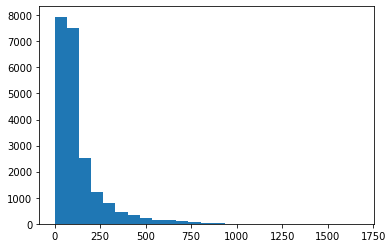

In [9]:
plt.hist(df.text.str.count(' '), bins=25) # approximate word count
plt.plot()

In [10]:
import numpy as np
from functools import reduce

In [11]:
topic_labels, topic_label_counts = np.unique(reduce(lambda l1, l2: l1 + l2, df['topics'].tolist()), return_counts=True)
print('num topics:', len(topic_labels))

num topics: 120


In [12]:
sort_idx = np.argsort(-topic_label_counts)
topic_label_counts = topic_label_counts[sort_idx]
topic_labels = topic_labels[sort_idx]
{l:c for c, l in zip(topic_label_counts, topic_labels)}

{'acq': 2448,
 'alum': 63,
 'austdlr': 4,
 'barley': 54,
 'bfr': 1,
 'bop': 116,
 'can': 3,
 'carcass': 75,
 'castor-oil': 2,
 'castorseed': 1,
 'citruspulp': 1,
 'cocoa': 76,
 'coconut': 6,
 'coconut-oil': 7,
 'coffee': 145,
 'copper': 78,
 'copra-cake': 3,
 'corn': 254,
 'corn-oil': 1,
 'cornglutenfeed': 2,
 'cotton': 63,
 'cotton-oil': 3,
 'cottonseed': 1,
 'cpi': 112,
 'cpu': 4,
 'crude': 634,
 'cruzado': 1,
 'dfl': 3,
 'dkr': 1,
 'dlr': 217,
 'dmk': 15,
 'earn': 3987,
 'f-cattle': 3,
 'fishmeal': 2,
 'fuel': 28,
 'gas': 65,
 'gnp': 163,
 'gold': 135,
 'grain': 628,
 'groundnut': 10,
 'groundnut-oil': 2,
 'heat': 25,
 'hk': 1,
 'hog': 27,
 'housing': 21,
 'income': 18,
 'instal-debt': 7,
 'interest': 513,
 'inventories': 7,
 'ipi': 65,
 'iron-steel': 67,
 'jet': 8,
 'jobs': 76,
 'l-cattle': 9,
 'lead': 35,
 'lei': 17,
 'lin-meal': 1,
 'lin-oil': 2,
 'linseed': 2,
 'lit': 3,
 'livestock': 114,
 'lumber': 17,
 'meal-feed': 51,
 'money-fx': 801,
 'money-supply': 190,
 'naphtha': 7,
 '

In [13]:
keep_topics = topic_labels[topic_label_counts > 10]
print(len(keep_topics), keep_topics)

66 ['earn' 'acq' 'money-fx' 'crude' 'grain' 'trade' 'interest' 'wheat' 'ship'
 'corn' 'dlr' 'oilseed' 'money-supply' 'sugar' 'gnp' 'coffee' 'veg-oil'
 'gold' 'nat-gas' 'soybean' 'bop' 'livestock' 'cpi' 'reserves' 'copper'
 'cocoa' 'jobs' 'carcass' 'yen' 'iron-steel' 'rice' 'ipi' 'gas' 'alum'
 'cotton' 'barley' 'rubber' 'meal-feed' 'zinc' 'palm-oil' 'pet-chem'
 'silver' 'rapeseed' 'sorghum' 'lead' 'tin' 'wpi' 'strategic-metal'
 'orange' 'fuel' 'hog' 'retail' 'soy-meal' 'heat' 'soy-oil' 'stg'
 'housing' 'income' 'sunseed' 'lumber' 'lei' 'dmk' 'tea' 'oat' 'platinum'
 'nickel']


In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

# binary encode the tags
lb = MultiLabelBinarizer().fit([[l] for l in keep_topics])
label_names = lb.classes_
Y = lb.transform(
    [[l for l in v if l in keep_topics]
     for v in df.topics.values])

print('num_nonempty_docs with keep_topics:', (Y.sum(axis=1) > 0).sum())


num_nonempty_docs with keep_topics: 11335


In [15]:
df['labels'] = [ls.tolist() for ls in Y]

In [48]:
i_train = np.array(df.lewissplit == 'TRAIN')
i_test = np.array(df.lewissplit == 'TEST')

df_train = df[i_train]
df_test = df[i_test]
print('train %:', len(df_train) / len(df))
print('test %:', len(df_test) / len(df))

train %: 0.6797664287700436
test %: 0.2867735656687367


###Calculate classification baseline

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# get the TF-IDF of the text
vec = TfidfVectorizer(min_df=2, sublinear_tf=True, decode_error='ignore')
X = vec.fit_transform(df.text)
X

<21578x25995 sparse matrix of type '<class 'numpy.float64'>'
	with 1560768 stored elements in Compressed Sparse Row format>

In [18]:
Xtr, ytr = X[i_train,:], Y[i_train,:]
Xte, yte = X[i_test,:], Y[i_test,:]
print(Xtr.shape, Xte.shape)

(14668, 25995) (6188, 25995)


In [19]:
# Baseline classifier: TF-IDF with K-NN classification
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(Xtr, ytr)

yte_pred = knn_model.predict(Xte)
print(classification_report(yte, yte_pred, target_names=label_names))

                 precision    recall  f1-score   support

            acq       0.83      0.01      0.01       719
           alum       0.00      0.00      0.00        23
         barley       1.00      0.14      0.25        14
            bop       0.50      0.03      0.06        30
        carcass       0.00      0.00      0.00        18
          cocoa       0.00      0.00      0.00        18
         coffee       1.00      0.04      0.07        28
         copper       1.00      0.06      0.11        18
           corn       0.92      0.21      0.35        56
         cotton       0.00      0.00      0.00        20
            cpi       1.00      0.04      0.07        28
          crude       1.00      0.19      0.31       189
            dlr       1.00      0.02      0.04        44
            dmk       0.00      0.00      0.00         4
           earn       0.45      0.03      0.06      1088
           fuel       1.00      0.20      0.33        10
            gas       1.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

###Train transformer model from pretrained english model

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


(array([4.957e+03, 8.238e+03, 3.388e+03, 1.947e+03, 1.004e+03, 6.020e+02,
        3.980e+02, 2.850e+02, 1.940e+02, 1.470e+02, 1.390e+02, 1.130e+02,
        8.800e+01, 4.100e+01, 1.900e+01, 6.000e+00, 8.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([   0.  ,   76.48,  152.96,  229.44,  305.92,  382.4 ,  458.88,
         535.36,  611.84,  688.32,  764.8 ,  841.28,  917.76,  994.24,
        1070.72, 1147.2 , 1223.68, 1300.16, 1376.64, 1453.12, 1529.6 ,
        1606.08, 1682.56, 1759.04, 1835.52, 1912.  , 1988.48, 2064.96,
        2141.44, 2217.92, 2294.4 , 2370.88, 2447.36, 2523.84, 2600.32,
        2676.8 , 2753

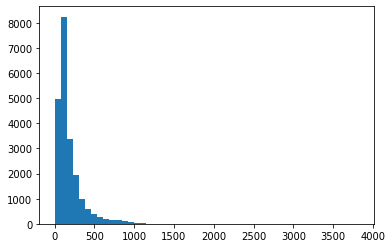

In [20]:
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
seq_lens = [len(tokenizer.tokenize(t)) for t in df.text]
plt.hist(seq_lens, bins=50)

Quite long documents. The default max sequence length of 128 tokens for MultiLabelClassificationModel would cut off many documents. Would be good to use sliding window/stride which splits the text into pieces without truncating them. The support for this in  but this in simpletransformers is experimental but can be used with a workaround.

Note: MultiLabelClassificationModel uses the metric Label ranking average precision (LRAP) https://scikit-learn.org/stable/modules/generated/sklearn.metrics.label_ranking_average_precision_score.html which seems sensible for this kind of multilabel classification.

In [66]:
from simpletransformers.classification import MultiLabelClassificationModel
import logging
from sklearn.model_selection import train_test_split

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns, a 'text' and a 'labels' column. The `labels` column should contain multi-hot encoded lists.
train_df = pd.DataFrame({'text': df_train.text.values, 'labels':df_train.labels.values})
test_df = pd.DataFrame({'text': df_test.text.values, 'labels':df_test.labels.values})

# Create a MultiLabelClassificationModel
model = MultiLabelClassificationModel('roberta', 'distilroberta-base', # distilroberta-base is a bit faster to train than 'roberta-base',
                                      num_labels=len(keep_topics), use_cuda=True,
                                      args={
                                            'sliding_window': True,
                                            'label_list': label_names,
                                            'reprocess_input_data': True,
                                            'overwrite_output_dir': True,
                                            'num_train_epochs': 1,
                                            'fp16': True,
                                            #'fp16_opt_level': 'O2',
                                            #'max_seq_length': 256,
                                            #'evaluate_during_training': True
                                            })
# You can set class weights by using the optional weight argument
print(train_df.head())

# Train the model
model.train_model(train_df)#, eval_df=test_df)

- This IS expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForMultiLabelSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
INFO:simpletransformers.classification.classification_model: Sliding window enabled


                                                text                                             labels
0  INCO SEES NO MAJOR IMPACT FROM DOW REMOVAL\nIn...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  FORMER EMPIRE OF CAROLINA <EMP> EXEC SENTENCED...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
2  DOCTORS FIND LINK BETWEEN AIDS, SMALLPOX VIRUS...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
3  BIRTH CONTROL PILLS HELP PREVENT CANCER - STUD...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4  U.S. ECONOMIC DATA KEY TO DEBT FUTURES OUTLOOK...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


INFO:simpletransformers.classification.classification_model: 31866 features created from 14668 samples.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.


### Transformer model evaluation

In [90]:
# Evaluate the model
model.args.sliding_window = False # Can train multilabel with sliding_window but not predict, so disable here 
result, model_outputs, wrong_predictions = model.eval_model(test_df)
print(result)
print('tags in preds:', (model_outputs > 0.5).sum())
print('tags in test set: ', sum([sum(ls) for ls in test_df.labels]))
from sklearn.metrics import classification_report
print(classification_report(np.array([np.array(l) for l in test_df.labels.values]),
                            (model_outputs > 0.5).astype(int),
                            target_names=label_names))

# Test something else
predictions, raw_outputs = model.predict(['oil to make gasoline']) # aka crude oil
max_pred_i = np.argmax(raw_outputs[0])
print('pred class:', label_names[max_pred_i], raw_outputs[0][max_pred_i])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1

{'LRAP': 0.9184846620014195, 'eval_loss': 0.02149274017546297}
tags in preds: 2923
tags in test set:  3703
                 precision    recall  f1-score   support

            acq       0.81      0.90      0.86       719
           alum       0.00      0.00      0.00        23
         barley       0.00      0.00      0.00        14
            bop       0.00      0.00      0.00        30
        carcass       0.00      0.00      0.00        18
          cocoa       0.00      0.00      0.00        18
         coffee       0.00      0.00      0.00        28
         copper       0.00      0.00      0.00        18
           corn       0.00      0.00      0.00        56
         cotton       0.00      0.00      0.00        20
            cpi       0.00      0.00      0.00        28
          crude       0.79      0.78      0.78       189
            dlr       0.00      0.00      0.00        44
            dmk       0.00      0.00      0.00         4
           earn       0.67      0.98 


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
pred class: crude 0.63623047


The transformer model makes no predictions at all for many of the low frequency classes which decreases the macro average F1-score to 0.07 which is below the baseline of 0.11. But the more representative measure is the micro average F1 score which is much higher at 0.64 instead of 0.12. Lowering the classification threshold to get the same macro F1 score of 0.11 actually gives a slightly higher micro F1-score with a decrease of micro accuracy to 0.61 instead of 0.73 - see report below.

In [95]:
print(classification_report(np.array([np.array(l) for l in test_df.labels.values]),
                            (model_outputs > 0.2).astype(int),
                            target_names=label_names))

                 precision    recall  f1-score   support

            acq       0.72      0.95      0.81       719
           alum       0.00      0.00      0.00        23
         barley       0.00      0.00      0.00        14
            bop       0.00      0.00      0.00        30
        carcass       0.00      0.00      0.00        18
          cocoa       0.00      0.00      0.00        18
         coffee       0.00      0.00      0.00        28
         copper       0.00      0.00      0.00        18
           corn       0.33      0.79      0.47        56
         cotton       0.00      0.00      0.00        20
            cpi       0.00      0.00      0.00        28
          crude       0.58      0.92      0.71       189
            dlr       0.73      0.18      0.29        44
            dmk       0.00      0.00      0.00         4
           earn       0.65      0.99      0.78      1088
           fuel       0.00      0.00      0.00        10
            gas       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1